This file applies for multiClass network

# HELPERS

In [1]:
import numpy as np
import pickle
import tensorflow as tf
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import pandas as pd
from collections import defaultdict
import random
import ast

def load_files_from_folders(folders, max_files):
    file_list = []
    for folder in folders:
        for i in range(max_files):
            file = ''.join([folder, str(i)])
            file_list.append(file)
    return file_list

def read_file(filename):
  with open(filename, "rb") as file:
      stat = pickle.load(file)
      file.close()
  return stat

def split_dataset(files, train_ratio, val_ratio):
    random.shuffle(files)

    total_files = len(files)
    train_size = int(total_files * train_ratio)
    val_size = int(total_files * val_ratio)

    train_files = files[:train_size]
    val_files = files[train_size:train_size + val_size]
    test_files = files[train_size + val_size:]

    return train_files, val_files, test_files

# Need to load all files in dataset to get unique path dict
def path_encoder(files):
    path_sample = []
    for file_name in files:
        stat = read_file(file_name)
        path_sample.append(stat["data"]["paths_link"])

    all_path_link = [path_sample[i].values() for i in range(len(path_sample))]
    unique_values_set = {tuple(p) for path_set in all_path_link for path in path_set for p in path}
    path_set_dict = {v: k for k, v in enumerate(unique_values_set, start=1)}
    return path_set_dict

def normalize(tensor):
    scaler = MinMaxScaler()
    normed = scaler.fit_transform(tensor)
    return normed

def normalizeY(tensor):
    scaler = MinMaxScaler()
    normed = scaler.fit_transform(tensor)
    return normed, scaler

# def normalizeY(tensor):
#     # Normalize by row
#     if not isinstance(tensor, np.ndarray):
#         tensor = np.array(tensor)
#     scaler = MinMaxScaler()
#     normed = scaler.fit_transform(np.transpose(tensor))
#     tensor = np.transpose(normed)
#     tensor = tensor[:, :-1] # get 1st 3 columns, ignore the last column of demand
#     return tensor, scaler

def create_matrix(data, nodes):
    matrix = np.zeros((len(nodes), len(nodes)), dtype=float)
    # matrix = np.zeros((24, 24), dtype=float)
    for (o, d), v in data:
        matrix[int(o)-1][int(d)-1] = v
    return matrix.reshape(-1, 1)

def get_graphMatrix(network, nodes):
    # 625x4
    # cap = np.array(network[['init_node', 'term_node', 'capacity']].apply(lambda row: ((row['init_node'], row['term_node']), row['capacity']), axis=1).tolist(), dtype=object)
    length = np.array(network[['init_node', 'term_node', 'length']].apply(lambda row: ((row['init_node'], row['term_node']), row['length']), axis=1).tolist(), dtype=object)
    fft_c = np.array(network[['init_node', 'term_node', 'free_flow_time']].apply(lambda row: ((row['init_node'], row['term_node']), row['free_flow_time']), axis=1).tolist(), dtype=object)
    fft_t = np.array(network[['init_node', 'term_node', 'fft_t']].apply(lambda row: ((row['init_node'], row['term_node']), row['fft_t']), axis=1).tolist(), dtype=object)

    # Cap = create_matrix(cap, nodes)
    Length = create_matrix(length, nodes)
    Fft_c = create_matrix(fft_c, nodes)
    Fft_t = create_matrix(fft_t, nodes)

    # matrix = np.concatenate((normalize(Cap), np.log1p(Length), np.log1p(Fft_c), np.log1p(Fft_t)), axis=1)
    matrix = np.concatenate((np.log1p(Length), np.log1p(Fft_c), np.log1p(Fft_t)), axis=1)
    return matrix

def get_demandMatrix(demand, nodes):
    matrix_c = np.array([(key, value[0]) for key, value in demand.items()], dtype=object)
    matrix_t = np.array([(key, value[1]) for key, value in demand.items()], dtype=object)
    matrix_c = create_matrix(matrix_c, nodes)
    matrix_t = create_matrix(matrix_t, nodes)
    return matrix_c, matrix_t

# Get 3 feasible paths for each OD pair, return tensor shape 625x3
def get_pathMatrix(path_links, nodes, unique_set):
    # 625x3
    paths = np.array([(key, [tuple(path) for path in value]) for key, value in path_links.items()], dtype=object)
    p1, p2, p3 = [], [], []
    for od, path_list in paths:
        path1 = path2 = path3 = 0

        if len(path_list) > 0:
            path1 = path_list[0]
        if len(path_list) > 1:
            path2 = path_list[1]
        if len(path_list) > 2:
            path3 = path_list[2]

        p1.append((od, unique_set[path1] if path1 != 0 else 0))
        p2.append((od, unique_set[path2] if path2 != 0 else 0))
        p3.append((od, unique_set[path3] if path3 != 0 else 0))
    p1 = create_matrix(p1, nodes)
    p2 = create_matrix(p2, nodes)
    p3 = create_matrix(p3, nodes)
    matrix = np.concatenate((p1, p2, p3), axis=1)
    return matrix

# Get path flow distribution (Y), return 2 tensors of dimension 3
def to_percentage_list(lst):
    total = sum(lst)
    if total == 0:
        return [0.0, 0.0, 0.0]
    return [x / total for x in lst]

def process_flows(demand, path_flows):
    flows = [[(od, path[i] if i < len(path) else 0) for i in range(3)] 
             for od, path in zip(demand.keys(), path_flows)]
    # Change the value to percentage
    # flows = [[f[0], to_percentage_list(list(f[1]))] for f in flows]
    return np.array(flows, dtype=object)

def get_flowMatrix(demand, path_flows, nodes_size):
    flow_c = process_flows(demand, [[f[i][0] for i in range(len(f))] for f in path_flows])
    flow_t = process_flows(demand, [[f[i][1] for i in range(len(f))] for f in path_flows])

    matrices_c = [create_matrix(flow_c[:, i], nodes_size) for i in range(3)]
    matrices_t = [create_matrix(flow_t[:, i], nodes_size) for i in range(3)]

    matrix_c = np.concatenate(matrices_c, axis=1)
    matrix_t = np.concatenate(matrices_t, axis=1)
    
    return matrix_c, matrix_t

# No mask model
def generate_xy(file_name, unique_set, test_set=None):
    stat = read_file(file_name)
    path_links = stat["data"]["paths_link"]
    demand = stat["data"]["demand"]
    nodes = stat["data"]["nodes"]
    net = stat["data"]["network"]
    net['fft'] = net['fft'].apply(lambda x: ast.literal_eval(x))
    net['fft_t'] = net['fft'].apply(lambda x: int(x[1]))

    path_flows = stat["path_flow"]

    # Get X
    Graph = get_graphMatrix(net, nodes) #return normalized data
    matrix_c, matrix_t = get_demandMatrix(demand, nodes)
    OD_demand = np.concatenate((matrix_c, matrix_t), axis=1)
    Path_tensor = get_pathMatrix(path_links, nodes, unique_set)

    X = np.concatenate((Graph, normalize(OD_demand), normalize(Path_tensor)), axis=1)
    X = tf.convert_to_tensor(X, dtype=tf.float32) # (nodexnode) x 9

    # # Get Y
    Y_c, Y_t = get_flowMatrix(demand, path_flows, nodes)
    Y_c = [to_percentage_list(y) for y in Y_c]
    Y_t = [to_percentage_list(y) for y in Y_t]
    # Y_c = np.concatenate((Y_c, matrix_c), axis=1)
    # Y_t = np.concatenate((Y_t, matrix_t), axis=1)
    Y_c, scaler_c = normalizeY(Y_c)
    Y_t, scaler_t = normalizeY(Y_t)
    
    Y_c = tf.convert_to_tensor(Y_c, dtype=tf.float32)
    Y_t = tf.convert_to_tensor(Y_t, dtype=tf.float32)

    # Concat Y car and Y truck, normalize by column, return 1 scaler.
    # Y = np.concatenate((Y_c, Y_t), axis=1)
    # Y, scaler = normalizeY(Y)
    # Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    if test_set:
        return X, Y_c, scaler_c, Y_t, scaler_t
    return X, Y_c, Y_t

    # if test_set:
    #     return X, Y, scaler
    # return X, Y

"""
CHECK UE CONDITIONS OF PREDICTED OUTPUT
"""

def get_origin_path(stat, type):
    path_link = stat['data']['paths_link']
    od = [k for k in path_link.keys()]
    path1 = [tuple(p[0]) if len(p) > 0 else np.nan for p in path_link.values()]
    path2 = [tuple(p[1]) if len(p) > 1 else np.nan for p in path_link.values()]
    path3 = [tuple(p[2]) if len(p) > 2 else np.nan for p in path_link.values()]

    demand_dic = stat["data"]["demand"]
    demand = [v for v in demand_dic.values()]
    path_link_df = pd.DataFrame({"od": od, "demand":demand, "path1": path1, "path2": path2, "path3": path3})

    if type=='c':
        path_link_df['demand'] = path_link_df['demand'].apply(lambda x: x[0])
    else: 
        path_link_df['demand'] = path_link_df['demand'].apply(lambda x: x[1])

    return path_link_df

def calculate_link_cost(row, type):
    if type == 'c':
        link_cost = round(row[0]*(1+0.15*((row[1]/row[2])**4)), 2)
    link_cost = round(row[0]*(1+0.15*((2.5 * row[1]/row[2])**4)), 2)
    return link_cost

# Calculate path cost for each od pair
def calculate_path_cost(row, link_df):
    if pd.isna(row): 
        return np.nan
    
    sum_cost = 0
    for link in row:
        sum_cost += link_df[link_df['link_id']==link].iloc[:, 1].iloc[0]
        
    return round(sum_cost, 2)

# calculate each link flow based on path flow
def extract_link_flow(path_link, flows):
    # input: a dictionary of {od pair: path_link} and list of flow distribution
    # return a dictionary of link flow
    path_flow = {}
    for path_set, flow_set in zip(path_link.values(), flows):
        for path, flow in zip(path_set, flow_set):
            path_flow[tuple(path)] = flow

    aggregated_sums = defaultdict(float)
    for path, flow in path_flow.items():
        for link in path:
            aggregated_sums[link] += flow
    link_flow = dict(aggregated_sums)
    return link_flow

# get dictionary of path flow for each OD pair from predicted tensor
def extract_path_flow(pred_tensor):
    x = int(np.sqrt(pred_tensor.shape[0]))
    pred1 = pred_tensor[:, 0].reshape(x, x)
    pred2 = pred_tensor[:, 1].reshape(x, x)
    pred3 = pred_tensor[:, 2].reshape(x, x)

    dict1 = {(i+1, j+1): pred1[i, j] for i in range(pred1.shape[0]) for j in range(pred1.shape[1])}
    dict2 = {(i+1, j+1): pred2[i, j] for i in range(pred2.shape[0]) for j in range(pred2.shape[1])}
    dict3 = {(i+1, j+1): pred3[i, j] for i in range(pred3.shape[0]) for j in range(pred3.shape[1])}

    final_dict = {}
    for key in dict1.keys():
        final_dict[key] = [dict1[key], dict2[key], dict3[key]]
    final_dict = {k: v for k, v in final_dict.items() if not all(val == 0 for val in v)}
    return final_dict

# 1
def create_pred_df(tensor, stat, type):
    # return a df of predicted path flow 
    final_dict = extract_path_flow(tensor) 
    pred_df = pd.DataFrame.from_dict(final_dict, orient='index', columns=['flow1', 'flow2', 'flow3']).reset_index()
    pred_df.rename(columns={'index': 'od'}, inplace=True)
    path_set = get_origin_path(stat, type)[['od', 'demand', 'path1', 'path2', 'path3']]

    pred_df = pd.merge(pred_df, path_set, how='right', on='od')
    nan_val = pred_df['flow1'].isna().sum()
    nan_num = round(nan_val/len(stat['path_flow']),2)

    pred_df = pred_df.fillna(0)
    pred_df.loc[pred_df['path1'] == 0, 'flow1'] = 0
    pred_df.loc[pred_df['path2'] == 0, 'flow2'] = 0
    pred_df.loc[pred_df['path3'] == 0, 'flow3'] = 0

    pred_df.loc[pred_df['flow1'] < 0, 'flow1'] = 0
    pred_df.loc[pred_df['flow2'] < 0, 'flow2'] = 0
    pred_df.loc[pred_df['flow3'] < 0, 'flow3'] = 0

    pred_df['flow1'] = pred_df['flow1'] * pred_df['demand']
    pred_df['flow2'] = pred_df['flow2'] * pred_df['demand']
    pred_df['flow3'] = pred_df['flow3'] * pred_df['demand']

    pred_df['flow1'] = round(pred_df['flow1'], 0)
    pred_df['flow2'] = round(pred_df['flow2'], 0)
    pred_df['flow3'] = round(pred_df['flow3'], 0)

    flows = stat['path_flow']
    if type=='c':
        path_flow = [[f[i][0] for i in range(len(f))] for f in flows]
    else: 
        path_flow = [[f[i][1] for i in range(len(f))] for f in flows]

    pred_df['UE_flow1'] = [f[0] if len(f)>0 else 0 for f in path_flow]
    pred_df['UE_flow2'] = [f[1] if len(f)>1 else 0 for f in path_flow]
    pred_df['UE_flow3'] = [f[2] if len(f)>2 else 0 for f in path_flow]

    return pred_df, len(stat['path_flow']), len(final_dict), nan_num

def compare_path_flow(pred_UE_path_flow):
    melted = pd.melt(pred_UE_path_flow,
                    value_vars=['path1', 'path2', 'path3', 'flow1', 'flow2', 'flow3', 'UE_flow1', 'UE_flow2', 'UE_flow3'],
                    var_name='variable', value_name='value')

    melted['path_type'] = melted['variable'].str.extract('(path|flow|UE_flow)')
    melted['id'] = melted.groupby('path_type').cumcount()

    compare = melted.pivot(index='id', columns='path_type', values='value').reset_index(drop=True)
    compare['abs_err'] = (compare['flow'] - compare['UE_flow']).abs()
    compare['sqr_err'] = compare['abs_err']**2
    compare['mape'] = compare[compare['UE_flow']!=0]['abs_err']/compare[compare['UE_flow']!=0]['UE_flow']*100
    # compare_path_flow[~compare_path_flow['mape'].isna()]['mape'].mean()
    return compare

# 2 - Get link flow and cost from predicted path flow
def compare_link_flow(pred_df, stat, type):
    pred_path_flow = pred_df[['flow1', 'flow2', 'flow3']].values.tolist()
    path_link = stat['data']['paths_link']

    pred_link_flow = extract_link_flow(path_link, pred_path_flow)
    pred_link_flow = pd.DataFrame.from_dict(pred_link_flow, orient='index', columns=['link_flow']).sort_index(ascending=True).reset_index()
    pred_link_flow.rename(columns={'index': 'link_id'}, inplace=True)

    link = stat['data']['network'].copy()
    link['fft'] = link['fft'].apply(lambda x: ast.literal_eval(x))
    if type == 'c':
        link['free_flow_time'] = link['fft'].apply(lambda x: int(x[0]))
    else: 
        link['free_flow_time'] = link['fft'].apply(lambda x: int(x[1]))

    output = pd.merge(link, pred_link_flow, how='left', on='link_id')
    output = output.fillna(0)
    output['link_cost'] = output[['free_flow_time','link_flow', 'capacity']].apply(lambda x: calculate_link_cost(x, type), axis=1)

    link_flow_c = [f[0] for f in stat['link_flow']]
    link_flow_t = [f[1] for f in stat['link_flow']]

    if type == 'c':
        output['UE_flow'] = output['link_id'].apply(lambda x: link_flow_c[x])

    else: 
        output['UE_flow'] = output['link_id'].apply(lambda x: link_flow_t[x])

    output['UE_link_cost'] = output[['free_flow_time','UE_flow', 'capacity']].apply(lambda x: calculate_link_cost(x, type), axis=1)
    output['abs_err'] = (output['link_flow'] - output['UE_flow']).abs()
    output['sqr_err'] = output['abs_err']**2
    output['mape'] = output[output['UE_flow']!=0]['abs_err']/output[output['UE_flow']!=0]['UE_flow']*100
    return output[['link_id', 'link_flow','link_cost','UE_flow','UE_link_cost','abs_err','sqr_err', 'mape']]
    # return output

# 3 - Avg delay of predicted/solution flow
def get_delay(path_flow, link_flow):
    path_flow['path1_cost'] = path_flow['path1'].apply(lambda x: calculate_path_cost(x,link_flow))
    path_flow['path2_cost'] = path_flow['path2'].apply(lambda x: calculate_path_cost(x,link_flow))
    path_flow['path3_cost'] = path_flow['path3'].apply(lambda x: calculate_path_cost(x,link_flow))
    path_flow['min_path_cost'] = path_flow[['path1_cost', 'path2_cost', 'path3_cost']].min(axis=1)
    path_flow = path_flow.fillna(0)
    path_flow['delay'] = (
        path_flow['flow1'] * (path_flow['path1_cost'] - path_flow['min_path_cost']) +
        path_flow['flow2'] * (path_flow['path2_cost'] - path_flow['min_path_cost']) +
        path_flow['flow3'] * (path_flow['path3_cost'] - path_flow['min_path_cost'])
    )
    avg_delay = path_flow['delay'].sum()/path_flow['demand'].sum()
    mean_path_cost = (np.nanmean(path_flow['path1_cost']) + np.nanmean(path_flow['path2_cost']) + np.nanmean(path_flow['path3_cost']))/3
    return path_flow, avg_delay, mean_path_cost

def single_avg_delay(pred_tensor, filename, type):
    stat = read_file(filename)
    pred_UE_path_flow, len_origin, len_pred, nan_num = create_pred_df(pred_tensor, stat, type)
    path_flow_err = compare_path_flow(pred_UE_path_flow)
    pred_UE_link_flow = compare_link_flow(pred_UE_path_flow, stat, type)

    pred_delay, avg_pred_delay, pred_mean_cost = get_delay(pred_UE_path_flow.iloc[:, :8], pred_UE_link_flow[['link_id', 'link_cost']])

    UE_delay = pred_UE_path_flow[['od', 'demand', 'path1','path2','path3', 'UE_flow1','UE_flow2','UE_flow3']]
    UE_delay = UE_delay.rename(columns={'UE_flow1': 'flow1', 'UE_flow2': 'flow2', 'UE_flow3': 'flow3'})
    UE_delay, avg_UE_delay, UE_mean_cost = get_delay(UE_delay, pred_UE_link_flow[['link_id', 'UE_link_cost']])
    
    return [pred_UE_link_flow, path_flow_err],[avg_pred_delay, avg_UE_delay], [len_pred, len_origin], nan_num, [pred_mean_cost, UE_mean_cost]

def calculate_indicator(flowList):
    mse = np.mean([np.mean(flowList[x]['sqr_err']) for x in range(len(flowList))])
    mae = np.mean([np.mean(flowList[x]['abs_err']) for x in range(len(flowList))])
    rmse = np.sqrt(mse)
    mape = np.mean([np.mean(flowList[x]['mape']) for x in range(len(flowList))])
    return [round(mae,2), round(rmse,2), round(mape,2)]

# ATTENTION

In [3]:
import tensorflow as tf
from keras import layers as tfl
from keras import regularizers, Sequential
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.activations import sigmoid, linear, softmax

class EncoderLayer(tfl.Layer):
    def __init__(self, input_dim, d_model, heads, dropout, l2_reg):
        super().__init__()
        self.attn_layer = tfl.MultiHeadAttention(num_heads=heads, key_dim=d_model // heads, attention_axes=2)
        self.layer_norm1 = tfl.LayerNormalization(epsilon=1e-6)
        # leaky_relu = LeakyReLU(alpha=0.5)
        self.ffn = Sequential([
            tfl.Dense(d_model, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
            tfl.Dropout(dropout),
            tfl.Dense(input_dim, kernel_regularizer=regularizers.l2(l2_reg))
        ])
        self.dropout = tfl.Dropout(dropout)
        self.layer_norm2 = tfl.LayerNormalization(epsilon=1e-6)

    def call(self, x, training=None):
        attn_output = self.attn_layer(query=x, key=x, value=x)
        x = self.layer_norm1(x + self.dropout(attn_output))
        x = self.layer_norm1(self.dropout(x))

        ffn_output = self.ffn(x, training=training)
        x = self.layer_norm2(x + ffn_output)
        x = self.layer_norm2(self.dropout(x))
        return x

class Encoder(tfl.Layer):
    def __init__(self, input_dim, d_model, N, heads, dropout, l2_reg):
        super().__init__()
        self.layers = [EncoderLayer(input_dim, d_model, heads, dropout, l2_reg) for _ in range(N)]
        self.dense = tfl.Dense(3, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

    def call(self, x):
        output = x
        for layer in self.layers:
            output = layer(output)
        return self.dense(output)

class DecoderLayer(tfl.Layer):
    def __init__(self, output_dim, d_model, heads, dropout, l2_reg):
        super().__init__()
        self.mha1 = tfl.MultiHeadAttention(num_heads=heads, key_dim=d_model // heads, attention_axes=2)
        self.layer_norm1 = tfl.LayerNormalization(epsilon=1e-6)
        self.mha2 = tfl.MultiHeadAttention(num_heads=heads, key_dim=d_model // heads, attention_axes=2)
        self.layer_norm2 = tfl.LayerNormalization(epsilon=1e-6)
        # leaky_relu = LeakyReLU(alpha=0.5)
        self.ffn = Sequential([
            tfl.Dense(d_model, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
            tfl.Dropout(dropout),
            tfl.Dense(output_dim, kernel_regularizer=regularizers.l2(l2_reg))
        ])
        self.layer_norm3 = tfl.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tfl.Dropout(dropout)
        self.dropout2 = tfl.Dropout(dropout)
        self.dropout3 = tfl.Dropout(dropout)

    def call(self, x, encoder_output, training=None):
        attn1 = self.mha1(query=x, key=x, value=x, training=training)
        x = self.layer_norm1(x + self.dropout1(attn1))
        # x = self.layer_norm3(self.dropout3(x))

        attn2 = self.mha2(query=x, key=encoder_output, value=encoder_output, training=training)
        x = self.layer_norm2(x + self.dropout2(attn2))
        x = self.layer_norm3(self.dropout3(x))

        ffn_output = self.ffn(x, training=training)
        x = self.layer_norm3(x + ffn_output)
        x = self.layer_norm3(self.dropout3(x))
        return x

class Decoder(tfl.Layer):
    def __init__(self, output_dim, d_model, N, heads, dropout, l2_reg):
        super().__init__()
        self.layers = [DecoderLayer(output_dim, d_model, heads, dropout, l2_reg) for _ in range(N)]

    def call(self, x, encoder_output, training=None):
        output = x
        for layer in self.layers:
            output = layer(output, encoder_output, training=training)
        return output

class Transformer(tf.keras.Model):
    def __init__(self, input_dim, output_dim, d_model, E_layer, D_layer, heads, dropout, l2_reg):
        super().__init__()
        self.encoder = Encoder(input_dim, d_model, E_layer, heads, dropout, l2_reg)
        self.decoder = Decoder(output_dim, d_model, D_layer, heads, dropout, l2_reg)
        # self.decoder_t = Decoder(output_dim, d_model, D_layer, heads, dropout, l2_reg)
        self.activation = Activation('sigmoid')
        # self.activation_t = Activation('sigmoid')

    def call(self, x, y_c, y_t, training=None):
        encoder_output = self.encoder(x, training=training)
        out_c = self.decoder(y_c, encoder_output, training=training)
        out_t = self.decoder(y_t, encoder_output, training=training)

        out_c = self.activation(out_c)
        out_t = self.activation(out_t)
        
        return out_c, out_t

    def eval(self):
        for layer in self.encoder.layers:
            layer.trainable = False
        for layer in self.decoder.layers:
            layer.trainable = False
        # for layer in self.decoder_t.layers:
        #     layer.trainable = False

    def train(self):
        for layer in self.encoder.layers:
            layer.trainable = True
        for layer in self.decoder.layers:
            layer.trainable = True
        # for layer in self.decoder_t.layers:
        #     layer.trainable = True

    def fit(self, train_data_loader, val_data_loader, optimizer, loss_fn, epochs, device):
        # Define the early stopping callback
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            verbose=1,
            mode='min',
            restore_best_weights=True
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=0.0001,
            verbose=1
        )

        train_losses = []
        val_losses = []

        src, trg_c, trg_t = next(iter(train_data_loader))
        self(src, trg_c, trg_t, training=True)

        self.compile(optimizer=optimizer, loss=loss_fn)

        with tqdm(total=epochs, unit="epoch") as pbar:
            for epoch in range(epochs):
                # Training phase
                self.train()
                total_train_loss = 0
                for src, trg_c, trg_t  in train_data_loader:
                    with tf.device(device):
                        with tf.GradientTape() as tape:
                            output_c, output_t = self.call(src, trg_c, trg_t )
                            loss = loss_fn(trg_c, output_c) + loss_fn(trg_t, output_t)
                        
                        # Backpropagate and update the model
                        gradients = tape.gradient(loss, self.trainable_variables)
                        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
                        total_train_loss += loss.numpy()
                        pbar.set_description(f"Train Loss: {total_train_loss / len(train_data_loader):.4f}")

                # Validation phase
                self.eval()
                total_val_loss = 0
                for src, trg_c, trg_t in val_data_loader:
                    with tf.device(device):
                        output_c, output_t = self.call(src, trg_c, trg_t )
                        loss = loss_fn(trg_c, output_c) + loss_fn(trg_t, output_t)
                        total_val_loss += loss.numpy()

                        pbar.set_description(f"Val Loss: {total_val_loss / len(val_data_loader):.4f}")

                pbar.update(1)
                train_losses.append(total_train_loss / len(train_data_loader))
                val_losses.append(total_val_loss / len(val_data_loader))
                print(f"Epoch: {epoch+1} - Train Loss: {total_train_loss/len(train_data_loader):.4f}, Val Loss: {total_val_loss/len(val_data_loader):.4f}")

                # Check for early stopping
                if early_stopping.model is not None:
                    early_stopping.on_epoch_end(epoch, {'val_loss': total_val_loss / len(val_data_loader)})
                    reduce_lr.on_epoch_end(epoch, {'val_loss': total_val_loss / len(val_data_loader)})
                    if early_stopping.stopped_epoch > 0:
                        print(f"Early stopping triggered at epoch {early_stopping.stopped_epoch + 1}")
                        break
        return self, train_losses, val_losses

    # def predict(self, x):
    #     encoder_output = self.encoder(x, training=False)
    #     decoder_input = tf.zeros((tf.shape(x)[0], tf.shape(x)[1], 3))
    #     predictions = self.decoder(decoder_input, encoder_output, training=False)
    #     predictions = self.activation(predictions)
    #     return predictions

def inversed(normed, scaler):
    # normed: 625x3
    tensor = scaler.inverse_transform(np.transpose(normed))
    tensor = np.transpose(tensor)
    return tensor

def predict_withScaler(model, test_data_loader, scalers, device):
    model.eval()
    predicted_c, predicted_t = [], []
    scaler_idx = 0
    for src, trg_c, trg_t in test_data_loader:
        with tf.device(device):
            # output = model.predict(src, src_mask, tgt_mask)
            output_c, output_t = model.call(src, trg_c, trg_t)
            for i in range(len(src)):
                # pred_matrix_c = inversed(output_c[i].numpy(), scalers[0][scaler_idx]) # reverse transform by each row
                # pred_matrix_t = inversed(output_t[i].numpy(), scalers[1][scaler_idx])
                pred_matrix_c = scalers[0][scaler_idx].inverse_transform(output_c[i].numpy()) # inverse transform by column
                pred_matrix_t = scalers[1][scaler_idx].inverse_transform(output_t[i].numpy())
                predicted_c.append(pred_matrix_c)
                predicted_t.append(pred_matrix_t)
                scaler_idx +=1

    return predicted_c, predicted_t

def predict_percentage(model, test_data_loader, device):
    model.eval()
    predicted_c, predicted_t = [], []
    for src,  trg_c, trg_t  in test_data_loader:
        with tf.device(device):
            output_c, output_t = model.call(src, trg_c, trg_t )
            for i in range(len(src)):
                predicted_c.append(output_c[i].numpy())
                predicted_t.append(output_t[i].numpy())

    return predicted_c, predicted_t

# PARAMETERS

In [4]:
DATA_SIZE = 4000
FOLDERS = ['Solution/SiouxFalls/MultiClass/output'] 
# FOLDERS = ['Solution/SiouxFalls/Output2/5by5_Data'] 
TRAIN_RATE = 0.7 
VAL_RATE = 0.2
TEST_RATE = 0.1
BATCH_SIZE = 64

# TRAINING 
device = 'gpu'
input_dim = 8
output_dim = 3
d_model = 128
heads=8
E_layer = 8
D_layer = 2
epochs = 400
learning_rate = 0.001
dropout=0.1
l2_reg=1e-6

# CREATE DATASET

In [5]:
# files = load_files_from_folders(FOLDERS, max_files=100)
# path_set_dict = path_encoder(files)
unique_set = read_file('unique_paths.pkl')
print("Path set number: ", len(unique_set))

class Dataset:
    def __init__(self, files):
        # self.path_encoded = path_encoder()  # Get path encode dictionary
        self.X = []
        self.Y_c, self.Y_t = [], []

        for file_name in tqdm(files):
            x, y_c, y_t = generate_xy(file_name, unique_set)
            self.X.append(x)
            self.Y_c.append(y_c)
            self.Y_t.append(y_t)

        self.X = tf.stack(self.X, axis=0)
        self.Y_c = tf.stack(self.Y_c, axis=0)
        self.Y_t = tf.stack(self.Y_t, axis=0)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y_c[idx], self.Y_t[idx]

    def to_tf_dataset(self, batch_size):
        dataset = tf.data.Dataset.from_tensor_slices((self.X, self.Y_c, self.Y_t))
        dataset = dataset.shuffle(buffer_size=len(self.X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

def get_test_set(files):
    X = []
    Y_c, Y_t = [], []
    Scaler_c, Scaler_t = [], []
    for file_name in tqdm(files) :
        x, y_c, scaler_c, y_t, scaler_t = generate_xy(file_name, unique_set, test_set=True)
        X.append(x)
        Y_c.append(y_c)
        Y_t.append(y_t)
        Scaler_c.append(scaler_c)
        Scaler_t.append(scaler_t)

    X = tf.stack(X, axis=0)
    Y_c = tf.stack(Y_c, axis=0)
    Y_t = tf.stack(Y_t, axis=0)
    dataset = tf.data.Dataset.from_tensor_slices((X, Y_c, Y_t))
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset, (Scaler_c, Scaler_t)

Path set number:  3864


In [6]:
files = load_files_from_folders(FOLDERS, max_files=DATA_SIZE)
train_files, val_files, test_files1 = split_dataset(files, TRAIN_RATE, VAL_RATE)

train_dataset = Dataset(train_files)
train_data_loader = train_dataset.to_tf_dataset(BATCH_SIZE)

val_dataset = Dataset(val_files)
val_data_loader = train_dataset.to_tf_dataset(BATCH_SIZE)

test_data_loader, Scalers = get_test_set(test_files1)

# test_dataset = Dataset(test_files1)
# test_data_loader = test_dataset.to_tf_dataset(BATCH_SIZE)

  0%|          | 0/2800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

# TRAIN MODEL

In [7]:
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.losses import MeanSquaredError
import time
 
# normalize Y by row, difference normalize X 
# sigmoid activate
# ignore 1st layernorm in decoder
model = Transformer(input_dim=input_dim, output_dim=output_dim,
                    d_model=d_model, E_layer=E_layer, D_layer=D_layer,
                    heads=heads, dropout=dropout, l2_reg=l2_reg)
loss_fn = MeanSquaredError()
optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0, decay=l2_reg)

start = time.time()
model, train_loss, val_loss = model.fit(train_data_loader, val_data_loader, optimizer, loss_fn, epochs, device)
end = time.time()
train_time = end-start

  0%|          | 0/400 [00:00<?, ?epoch/s]

Epoch: 1 - Train Loss: 0.2814, Val Loss: 0.2734
Epoch: 2 - Train Loss: 0.2660, Val Loss: 0.2584
Epoch: 3 - Train Loss: 0.2514, Val Loss: 0.2443
Epoch: 4 - Train Loss: 0.2378, Val Loss: 0.2311
Epoch: 5 - Train Loss: 0.2250, Val Loss: 0.2188
Epoch: 6 - Train Loss: 0.2131, Val Loss: 0.2073
Epoch: 7 - Train Loss: 0.2021, Val Loss: 0.1967
Epoch: 8 - Train Loss: 0.1919, Val Loss: 0.1870
Epoch: 9 - Train Loss: 0.1825, Val Loss: 0.1781
Epoch: 10 - Train Loss: 0.1740, Val Loss: 0.1700
Epoch: 11 - Train Loss: 0.1664, Val Loss: 0.1627
Epoch: 12 - Train Loss: 0.1594, Val Loss: 0.1561
Epoch: 13 - Train Loss: 0.1531, Val Loss: 0.1501
Epoch: 14 - Train Loss: 0.1474, Val Loss: 0.1448
Epoch: 15 - Train Loss: 0.1423, Val Loss: 0.1399
Epoch: 16 - Train Loss: 0.1377, Val Loss: 0.1355
Epoch: 17 - Train Loss: 0.1335, Val Loss: 0.1315
Epoch: 18 - Train Loss: 0.1297, Val Loss: 0.1278
Epoch: 19 - Train Loss: 0.1262, Val Loss: 0.1245
Epoch: 20 - Train Loss: 0.1230, Val Loss: 0.1214
Epoch: 21 - Train Loss: 0.120

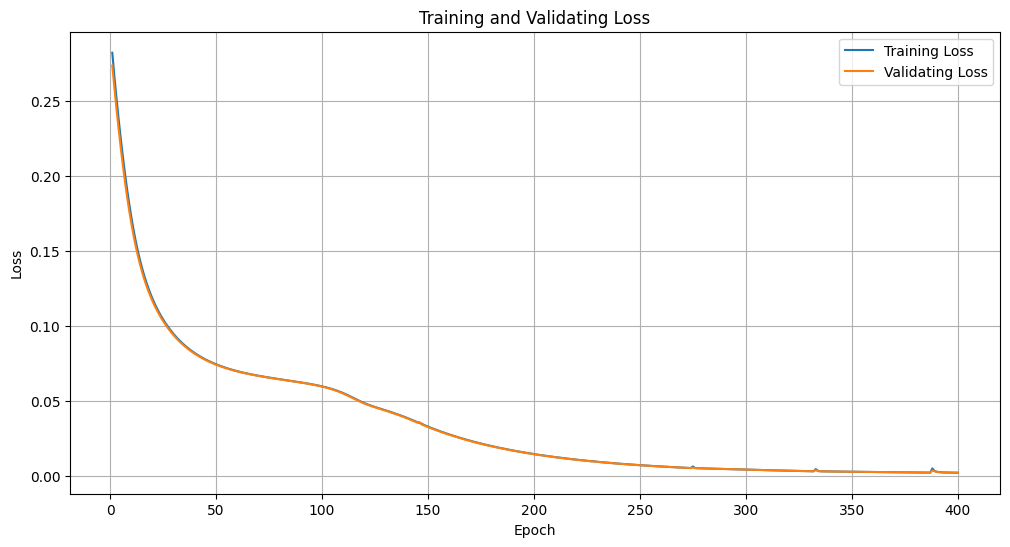

In [9]:
%run plotting.py
plot_loss(train_loss, val_loss, epochs)

# CHECK DELAY OF PREDICTED VALUES

In [10]:
import numpy as np
import pandas as pd

def aggregate_result(pred_tensor, test_files, type):
    size = len(test_files)
    Avg_delay, Solution_avg_delay, Len_origin, Len_pred, Nan_num, pred_mean_cost, UE_mean_path_cost = [], [], [], [], [], [], []
    Link_flow, Path_flow = [], []
    for i, filename in tqdm(zip(pred_tensor[:size], test_files[:size]), total=size):
        flows, delays, lens, nan_num, avg_path_cost = single_avg_delay(i, filename, type)

        Avg_delay.append(delays[0])
        Solution_avg_delay.append(delays[1])
        Len_pred.append(lens[0])
        Len_origin.append(lens[1])
        Nan_num.append(nan_num)
        pred_mean_cost.append(avg_path_cost[0])
        UE_mean_path_cost.append(avg_path_cost[1])
        Link_flow.append(flows[0])
        Path_flow.append(flows[1])

    # df = pd.DataFrame({
    #     'origin_od_pair': Len_origin,
    #     'pred_od_pair': Len_pred,
    #     'nan_percentage': Nan_num,
    #     'Pred_ad': Avg_delay,
    #     'Solution_ad': Solution_avg_delay
    # })

    p = np.mean(Avg_delay)
    s = np.mean(Solution_avg_delay)

    link_indicator = calculate_indicator(Link_flow)
    path_indicator = calculate_indicator(Path_flow)
    rows = ['MAE', 'RMSE', 'MAPE']
    result = pd.DataFrame({'Indicator': rows,
                        'Link flow': link_indicator,
                        'Path flow': path_indicator})
    return result, Link_flow, Path_flow, pred_mean_cost, UE_mean_path_cost, p, s

In [11]:
%run plotting.py

# Full links
predicted_c, predicted_t = predict_withScaler(model, test_data_loader, Scalers, device)
# predicted_c, predicted_t = predict_percentage(model, test_data_loader, device)

with open('predicted_result.pkl', "wb") as file:
    pickle.dump([predicted_c, predicted_t], file)

Convert Y to percentage, normalize by column 
* Car:
  Indicator  Link flow  Path flow \
0       MAE     533.56      10.96\
1      RMSE     672.09      38.94\
2      MAPE       2.42       3.48\
Avg predicted path cost:  11181.96 mins\
Prediction average delay:  116.3 mins =  1.04 %\
Solution average delay:  20.54 mins =  0.17 %\
Difference: 95.76 mins

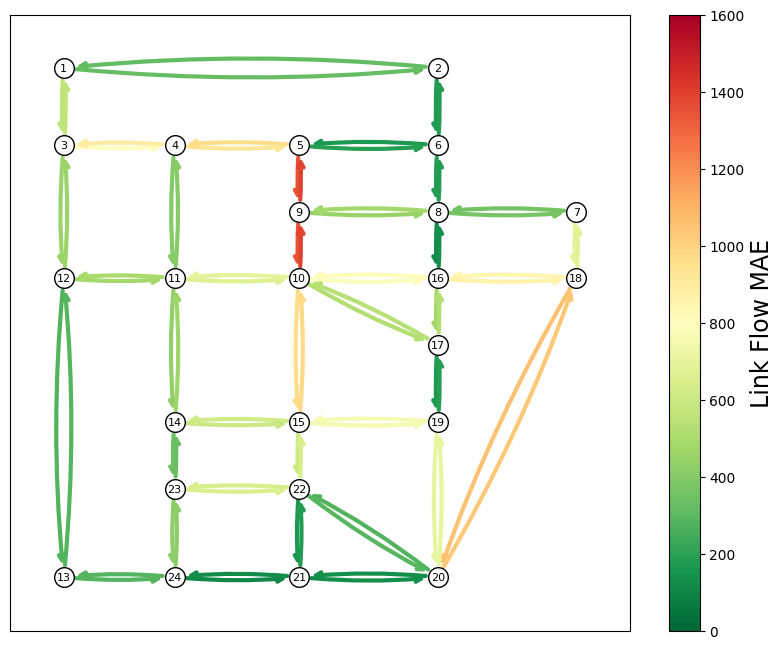

* Truck:
  Indicator  Link flow  Path flow\
0       MAE     289.21       5.92\
1      RMSE     359.79      20.17\
2      MAPE       2.63       3.66\
Avg predicted path cost:  835.45 mins\
Prediction average delay:  7.67 mins =  0.92 %\
Solution average delay:  0.88 mins =  0.1 %\
Difference: 6.79 mins

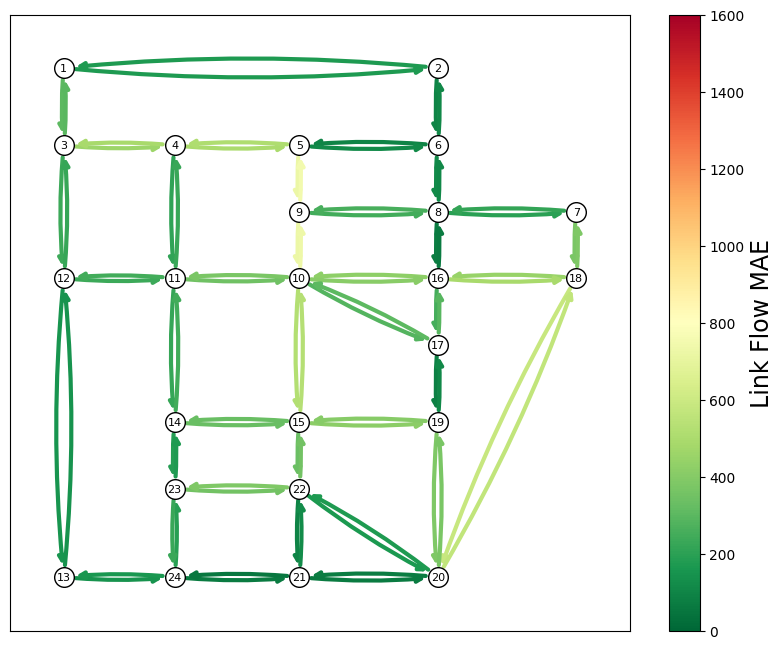

  0%|          | 0/400 [00:00<?, ?it/s]

  Indicator  Link flow  Path flow
0       MAE     610.30      13.40
1      RMSE     764.00      43.05
2      MAPE       2.77       4.51
Avg predicted path cost:  11251.11 mins
Prediction average delay:  135.7 mins =  1.21 %
Solution average delay:  20.88 mins =  0.17 %
Difference: 114.82 mins


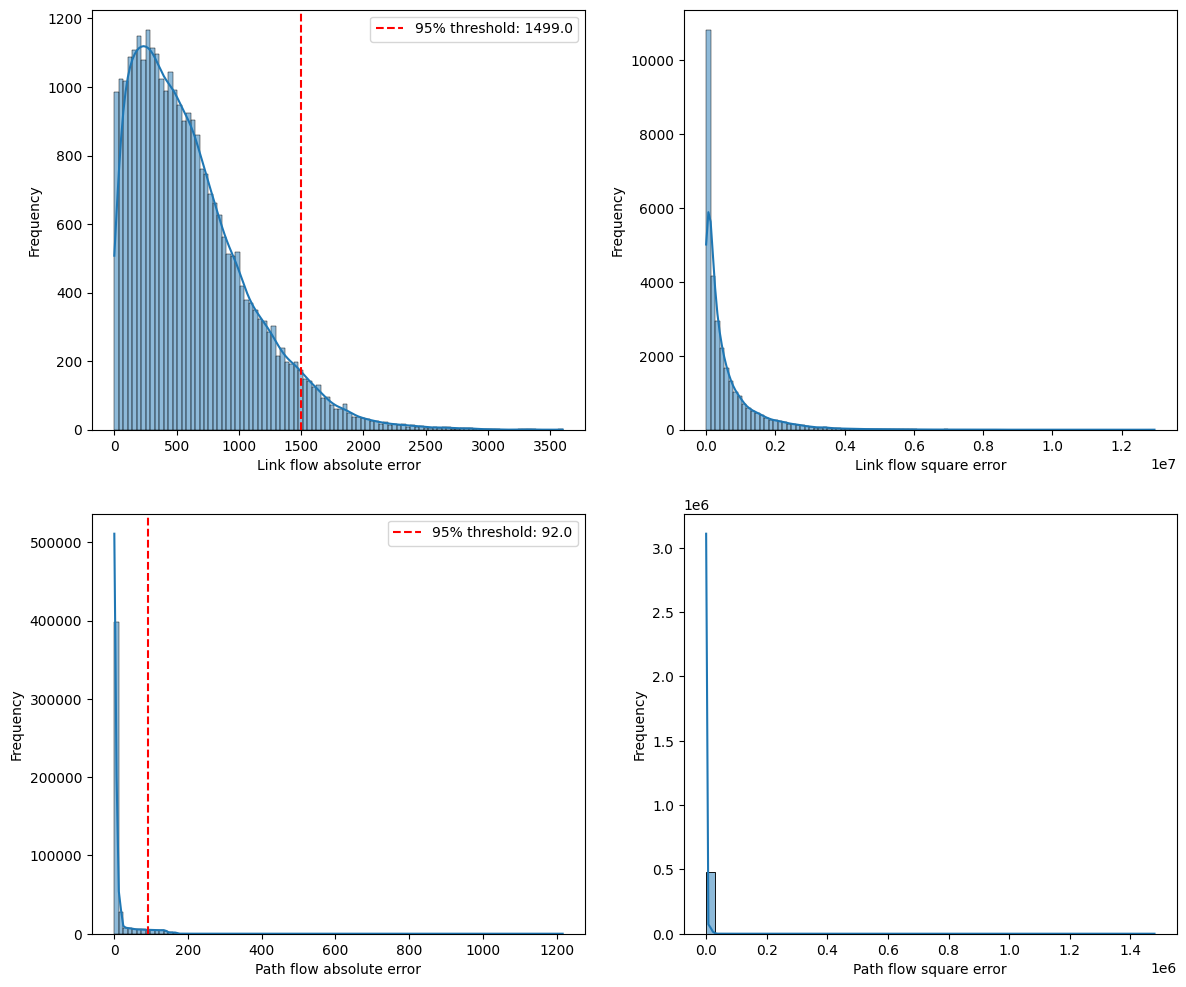

Min:  136.99958333333333
Max:  1612.3095833333334


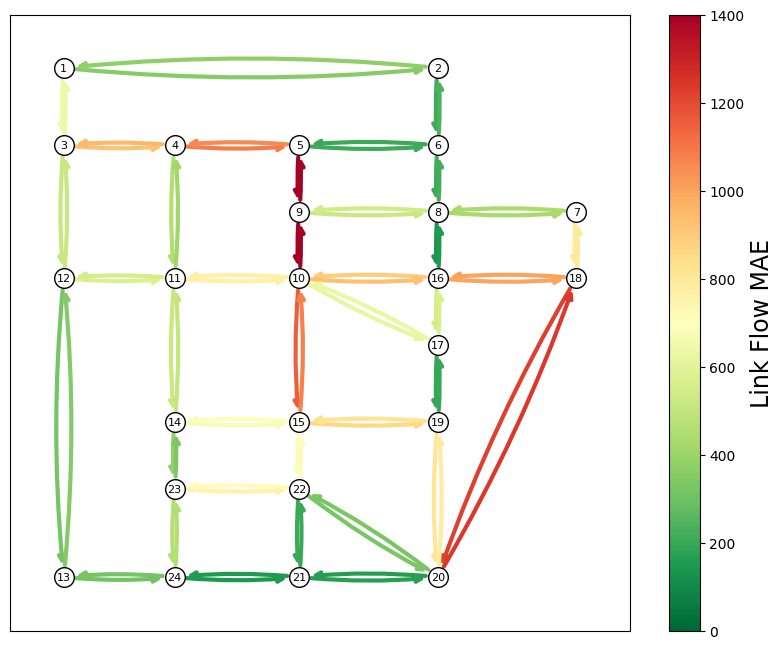

In [12]:
type = 'c'
result, Link_flow, Path_flow, pred_mean_cost, UE_mean_path_cost, p, s = aggregate_result(predicted_c, test_files1, type)

print(result)
print("Avg predicted path cost: ", round(np.mean(pred_mean_cost), 2), "mins")
print("Prediction average delay: ", round(p,2), "mins = ", round(p/np.mean(pred_mean_cost)*100, 2), "%")
print("Solution average delay: ", round(s, 2), "mins = ", round(s/np.mean(UE_mean_path_cost)*100, 2), "%")
print(f"Difference: {round(p-s,2)} mins")

plot_error(Link_flow, Path_flow)
Link_mae_df = heatmap_link_mae(Link_flow, test_files1[0])

  0%|          | 0/400 [00:00<?, ?it/s]

  Indicator  Link flow  Path flow
0       MAE     309.00       6.50
1      RMSE     387.38      22.16
2      MAPE       2.81       4.19
Avg predicted path cost:  844.45 mins
Prediction average delay:  8.43 mins =  1.0 %
Solution average delay:  0.87 mins =  0.1 %
Difference: 7.56 mins


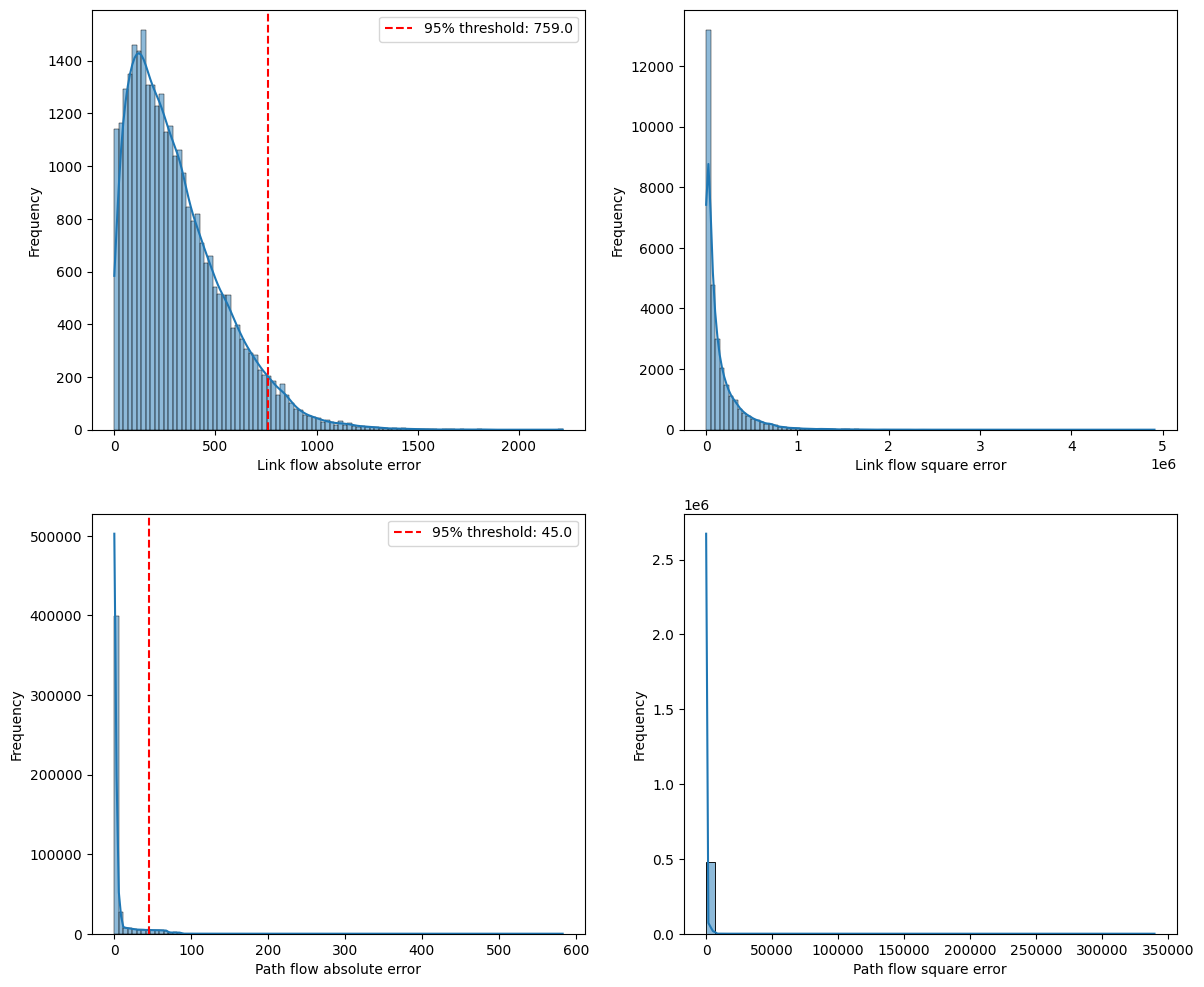

Min:  60.57833333333333
Max:  807.86875


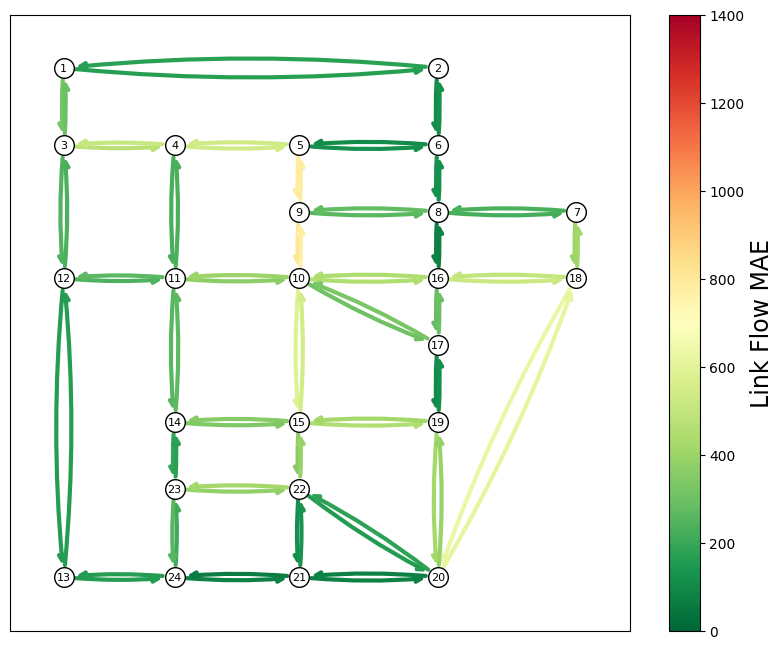

: 

In [13]:
type = 't'
result, Link_flow, Path_flow, pred_mean_cost, UE_mean_path_cost, p, s = aggregate_result(predicted_t, test_files1, type)

print(result)
print("Avg predicted path cost: ", round(np.mean(pred_mean_cost), 2), "mins")
print("Prediction average delay: ", round(p,2), "mins = ", round(p/np.mean(pred_mean_cost)*100, 2), "%")
print("Solution average delay: ", round(s, 2), "mins = ", round(s/np.mean(UE_mean_path_cost)*100, 2), "%")
print(f"Difference: {round(p-s,2)} mins")

plot_error(Link_flow, Path_flow)
Link_mae_df = heatmap_link_mae(Link_flow, test_files1[0])

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  Indicator  Link flow  Path flow
0       MAE     649.14      17.02
1      RMSE     771.63      45.66
2      MAPE       4.07       6.13
Avg path cost:  144.8 mins
Prediction average delay:  1.17 mins =  0.81 %
Solution average delay:  0.07 mins
Difference: 1.1 mins


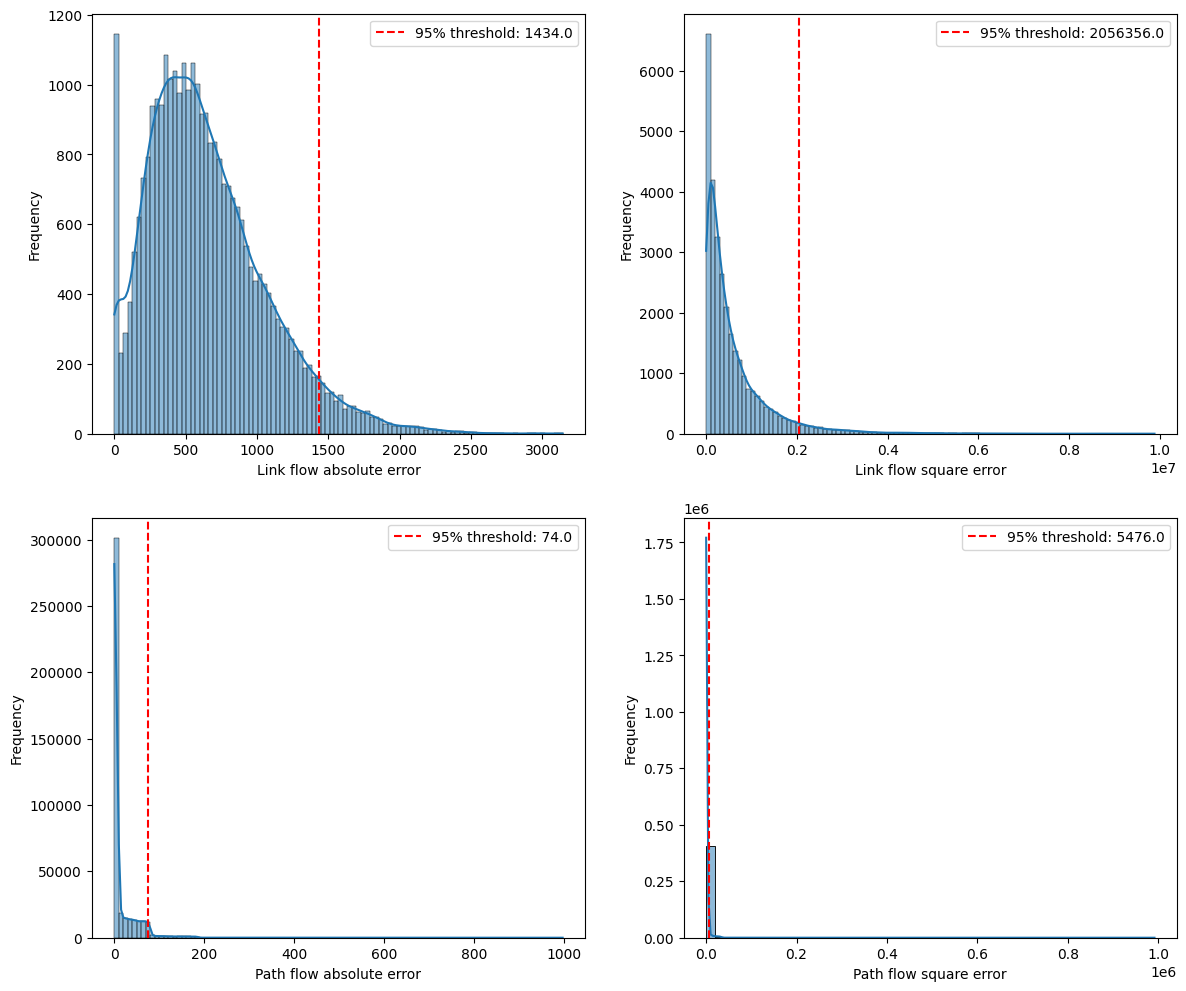

Min:  0.0
Max:  1541.32625


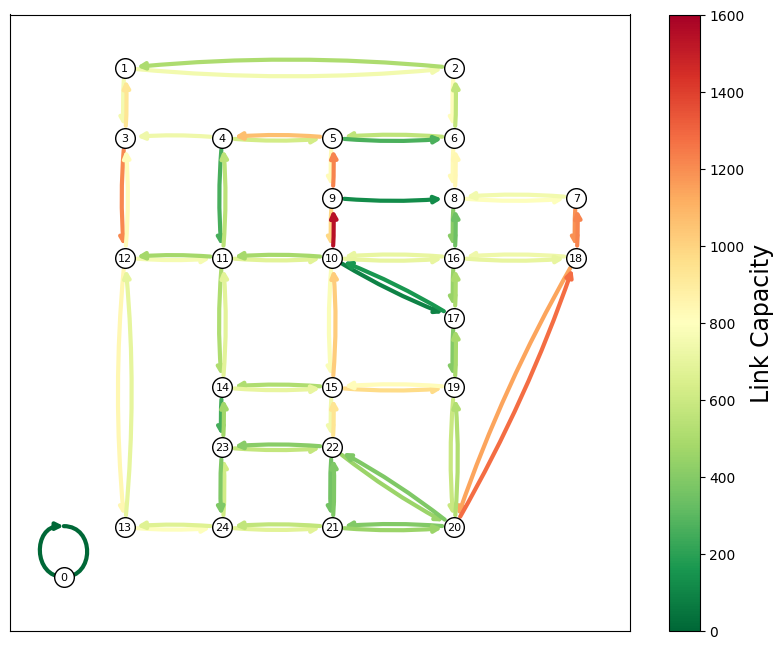

In [35]:
# Remove 2 links without retraining
TEST_FILES = ['Solution/SiouxFalls/Remove2/SiouxFall_UE_'] 
test_files = load_files_from_folders(TEST_FILES, max_files=400)
test_data_loader, scalers = get_test_set(test_files)

pred_tensor = predict_withScaler(model, test_data_loader, scalers, device)
result, Link_flow, Path_flow, Avg_path_cost, p, s = aggregate_result(pred_tensor, test_files)

print(result)
print("Avg path cost: ", round(np.mean(Avg_path_cost), 2), "mins")
print("Prediction average delay: ", round(p,2), "mins = ", round(p/np.mean(Avg_path_cost)*100, 2), "%")
print("Solution average delay: ", round(s, 2), "mins")
print(f"Difference: {round(p-s,2)} mins")

plot_error(Link_flow, Path_flow)
Link_mae_df = heatmap_link_mae(Link_flow, test_files[0])

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  Indicator  Link flow  Path flow
0       MAE     620.77      16.57
1      RMSE     740.75      43.87
2      MAPE       3.88       5.84
Avg path cost:  160.6629 mins
Prediction average delay:  1.1099 mins =  0.69 %
Solution average delay:  0.0621 mins
Difference: 1.0478 mins


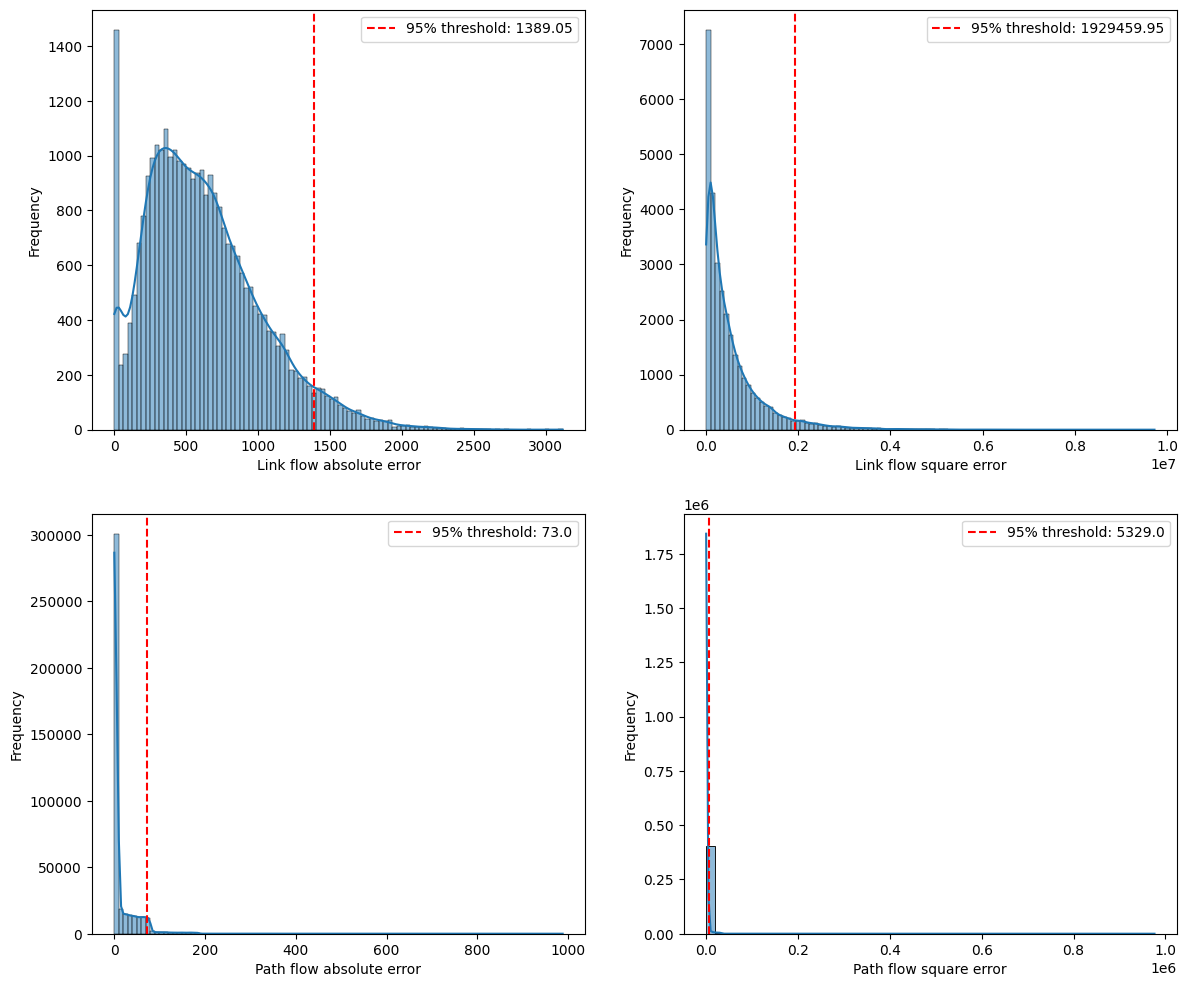

Min:  0.0
Max:  1421.52875


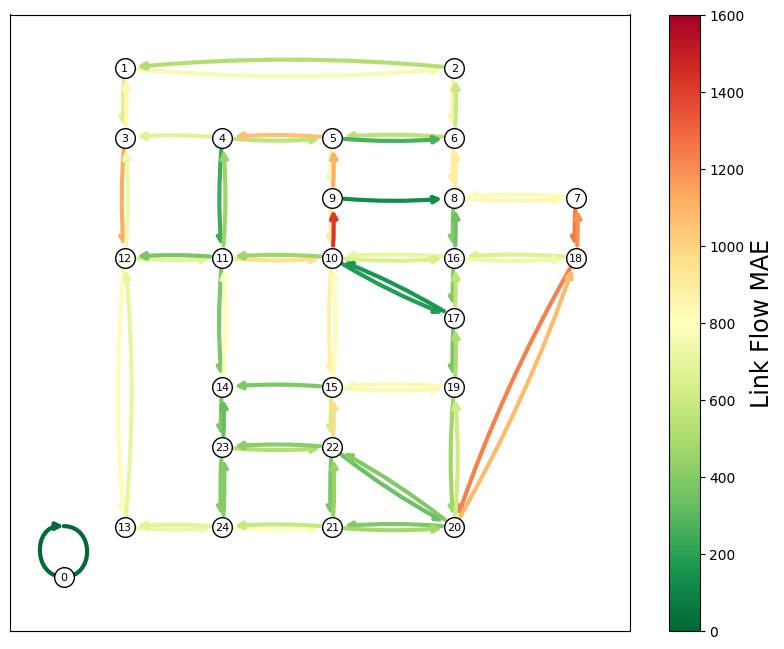

In [36]:
%run plotting.py

TEST_FILES = ['Solution/SiouxFalls/Remove3/SiouxFall_UE_'] 
test_files3 = load_files_from_folders(TEST_FILES, max_files=400)
test_data_loader, scalers = get_test_set(test_files3)

pred_tensor3 = predict_withScaler(model, test_data_loader, scalers, device)
result, Link_flow, Path_flow, Avg_path_cost, p, s = aggregate_result(pred_tensor3, test_files3)

print(result)
print("Avg path cost: ", round(np.mean(Avg_path_cost), 4), "mins")
print("Prediction average delay: ", round(p,4), "mins = ", round(p/np.mean(Avg_path_cost)*100, 2), "%")
print("Solution average delay: ", round(s, 4), "mins")
print(f"Difference: {round(p-s,4)} mins")

plot_error(Link_flow, Path_flow)
Link_mae_df = heatmap_link_mae(Link_flow, test_files3[0])

In [29]:
stat = read_file(test_files[0])
pred_df, len_origin, len_pred, nan_num = create_pred_df(pred_tensor[0], stat)

pred_link_flow = sum_pred_link_flow(pred_df, stat)
pred_df, pred_avg_delay = calculate_delay(pred_df, pred_link_flow)
pred_df

,od,demand,path1,path2,path3,flow1,flow2,flow3,path1_cost,path2_cost,path3_cost,min_path_cost,delay
0,"(15, 21)",1158,"(45, 68)","(45, 69, 72, 74)","(44, 58, 61)",1111.0,6.0,0.0,11.84,136.89,55.64,11.84,750.30
1,"(18, 17)",891,"(54, 48)","(55, 60, 57)","(53, 16, 21, 48)",855.0,4.0,0.0,20.01,28.13,50.80,20.01,32.48
2,"(8, 9)",1089,"(18, 14, 12)","(21, 47, 25)","(19, 17, 54, 47, 25)",0.0,6.0,987.0,206.19,157.34,157.92,157.34,572.46
3,"(19, 9)",414,"(57, 51, 47, 25)","(56, 42, 25)","(57, 50, 25)",0.0,413.0,0.0,175.08,37.24,45.94,37.24,0.00
4,"(19, 18)",524,"(57, 51, 49)","(58, 59)","(57, 51, 46, 19, 17)",0.0,523.0,0.0,37.49,30.18,69.81,30.18,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,"(4, 16)",658,"(8, 11, 15, 21)","(8, 12, 24, 28)","(9, 31, 28)",0.0,656.0,0.0,68.08,54.61,60.41,54.61,0.00
341,"(22, 15)",341,"(66,)","(67, 60, 56)","(69, 70, 40)",327.0,2.0,0.0,12.93,47.08,121.53,12.93,68.30
342,"(22, 24)",1641,"(68, 65)","(69, 72)","(66, 43, 41, 72)",0.0,1637.0,0.0,48.70,51.59,88.77,48.70,4730.93
343,"(15, 12)",287,"(43, 39, 32)","(45, 68, 65, 73, 37)","(45, 69, 72, 73, 37)",275.0,1.0,0.0,156.44,223.72,226.61,156.44,67.28


In [30]:
stat = read_file(test_files3[0])
pred_df, len_origin, len_pred, nan_num = create_pred_df(pred_tensor3[0], stat)

pred_link_flow = sum_pred_link_flow(pred_df, stat)
pred_df, pred_avg_delay = calculate_delay(pred_df, pred_link_flow)
pred_df

,od,demand,path1,path2,path3,flow1,flow2,flow3,path1_cost,path2_cost,path3_cost,min_path_cost,delay
0,"(15, 21)",1158,"(45, 68)","(45, 69, 72, 74)","(44, 58, 61)",1111.0,6.0,0.0,9.23,202.76,46.97,9.23,1161.18
1,"(18, 17)",891,"(54, 48)","(55, 60, 57)","(53, 16, 21, 48)",855.0,4.0,0.0,20.92,29.38,54.54,20.92,33.84
2,"(8, 9)",1089,"(18, 14, 12)","(21, 47, 25)","(19, 17, 54, 47, 25)",0.0,1086.0,0.0,216.70,170.75,171.75,170.75,0.00
3,"(19, 9)",414,"(57, 51, 47, 25)","(56, 42, 25)","(57, 50, 25)",0.0,413.0,0.0,178.61,37.11,43.78,37.11,0.00
4,"(19, 18)",524,"(57, 51, 49)","(58, 59)","(57, 51, 46, 19, 17)",0.0,523.0,0.0,28.69,23.46,60.36,23.46,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,"(4, 16)",658,"(8, 11, 15, 21)","(8, 12, 24, 28)","(9, 31, 28)",0.0,656.0,0.0,83.66,73.84,94.03,73.84,0.00
341,"(22, 15)",341,"(66,)","(67, 60, 56)","(68, 63, 60, 56)",327.0,2.0,0.0,18.48,59.28,59.20,18.48,81.60
342,"(22, 24)",1641,"(68, 65)","(69, 72)","(66, 43, 41, 72)",0.0,1637.0,0.0,51.63,50.45,87.43,50.45,0.00
343,"(15, 12)",287,"(43, 39, 32)","(45, 68, 65, 73, 37)","(45, 69, 72, 73, 37)",275.0,1.0,0.0,223.80,220.03,218.85,218.85,1362.43
